In [1]:
import sys
import os
sys.path.append(os.path.abspath("../clean_code"))

In [2]:
import numpy as np
from typing import Union, Optional, List, Any, Tuple, Callable, Dict
from itertools import product
import pandas
import matplotlib.pyplot as plt

from scipy.sparse.linalg import cg
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.datasets import fetch_openml

import importlib

import kmeans
import landmark
import voltagemap
import problem
import solver
import visualization
import setofpoints

In [3]:
importlib.reload(kmeans)
importlib.reload(landmark)
importlib.reload(voltagemap)
importlib.reload(problem)
importlib.reload(solver)
importlib.reload(visualization)
importlib.reload(setofpoints)

<module 'setofpoints' from '/home/avighna/Documents/python/VoltageDimentionalReduction/clean_code/setofpoints.py'>

# Test Space

In [4]:
print("Loading Data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.int64)

# Normalize pixel values to [0, 1]
X = X / 255.0

Loading Data...


In [5]:
X.shape

(70000, 784)

In [6]:
# X = X[:1000]
# y = y[:1000]

In [7]:
point_set = setofpoints.SetOfPoints(points=X)
point_set.shape

(70000, 784)

In [8]:
# compressor = kmeans.KMeans(k=1000)  # Reduce MNIST to 1000 centers
# compressed_set = compressor.fit_on_set(point_set)

In [9]:
# compressed_points = compressed_set.points
# compressed_weights = compressed_set.weights

In [10]:
# compressed_set = setofpoints.SetOfPoints(compressed_points, compressed_weights)
compressed_set = setofpoints.SetOfPoints(points=X[:1000])

In [11]:
# Select one sample per digit to serve as a landmark
landmarks = []
for digit in range(10):
    indices = np.where(y == digit)[0]
    # Choose the first occurrence as the landmark
    landmarks.append(landmark.Landmark.createLandmarkClosestTo(compressed_set, X[indices[0]], 1))

In [12]:
mnist_problem = problem.Problem(compressed_set, r=1)
mnist_problem.optimize(landmarks, radius=5, target_avg_voltage=0.7)
print(mnist_problem.r)

0.31622776601683805


In [13]:
# Initialize the map
voltage_map = voltagemap.VoltageMap()

# Compute voltages for each landmark and store in the map
for lm in landmarks:
    mnist_solver = solver.Solver(problem=mnist_problem)
    voltages = mnist_solver.compute_voltages(k=2, landmarks=[lm])
    voltage_map.add_solution(landmark_index=lm.index, voltages=voltages)

    print(voltages)

[0.0643599  1.         0.03899002 0.03648494 0.03974211 0.11496357
 0.04828749 0.05352924 0.04717156 0.04534285 0.05171929 0.03876635
 0.05678236 0.11276984 0.04939917 0.02964161 0.05368783 0.04390539
 0.06470224 0.03330725 0.03827243 0.78090827 0.03353828 0.03681374
 0.04074279 0.04452586 0.04208381 0.05228157 0.04665507 0.02200044
 0.04395606 0.04461663 0.08977627 0.0318653  0.38448349 0.03948849
 0.0753983  0.37932848 0.03689869 0.10345874 0.04366205 0.05841751
 0.03801091 0.03378345 0.06259537 0.03792848 0.0486743  0.04087667
 0.05185224 0.05253445 0.0638947  0.44259693 0.033159   0.03707924
 0.         0.05054107 0.31531402 0.03375046 0.0401541  0.04382677
 0.03851478 0.03806087 0.08054466 0.46382024 0.04945615 0.03851714
 0.10188045 0.04258431 0.31667989 0.38828565 0.04635669 0.02263822
 0.04930317 0.09740783 0.06467856 0.41589624 0.04446889 0.04279389
 0.0290178  0.02221235 0.06455489 0.3945479  0.10491312 0.09774297
 0.03621725 0.0464968  0.04970193 0.03378413 0.31987881 0.0437

points.shape (1000, 13)


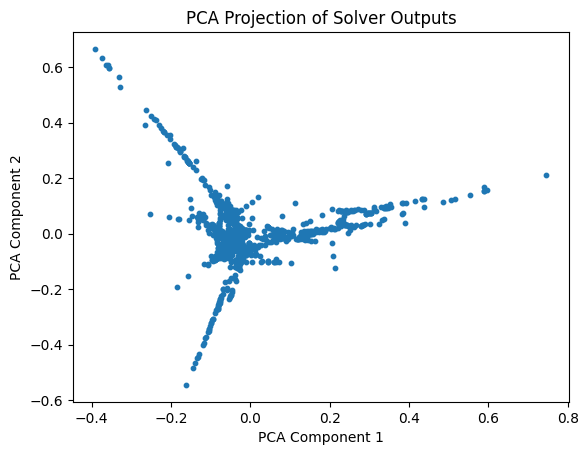

(1000, 2)


<Figure size 640x480 with 0 Axes>

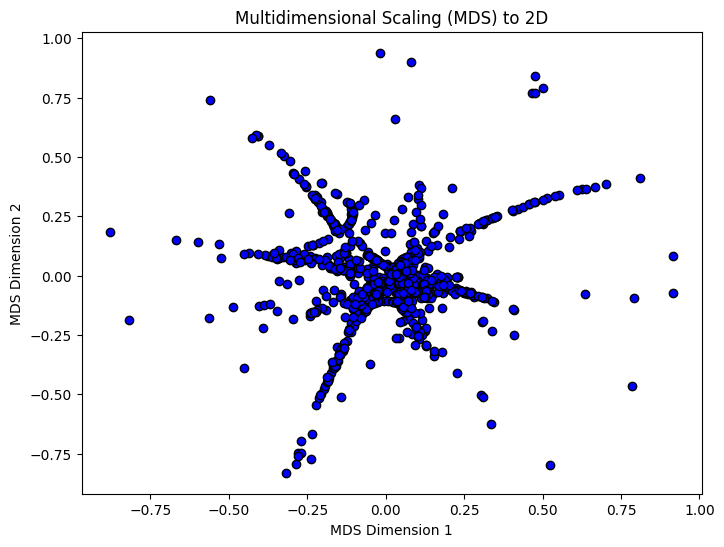

<Figure size 640x480 with 0 Axes>

In [14]:
points = np.array(list(map(list, zip(*voltage_map.voltage_maps))))

print('points.shape',points.shape)

# PCA
pca = PCA(n_components=2)
points_2d = pca.fit_transform(points)

# print(points_2d.shape)

plt.scatter(points_2d[:, 0], points_2d[:, 1], s=10)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Solver Outputs")

plt.show()
# plt.savefig(fileStarter + "_PCA.png")
plt.clf()

# MDS
mds = MDS(n_components=2, random_state=42)
transformed_points = mds.fit_transform(points)

print(transformed_points.shape)

plt.figure(figsize=(8, 6))
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='blue', edgecolors='black')

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("Multidimensional Scaling (MDS) to 2D")

# plt.savefig(fileStarter + "_MDS.png")
plt.show()
plt.clf()

Incorrect predictions: 472/1000
Accuracy: 52.80%
Error Rate: 47.20%


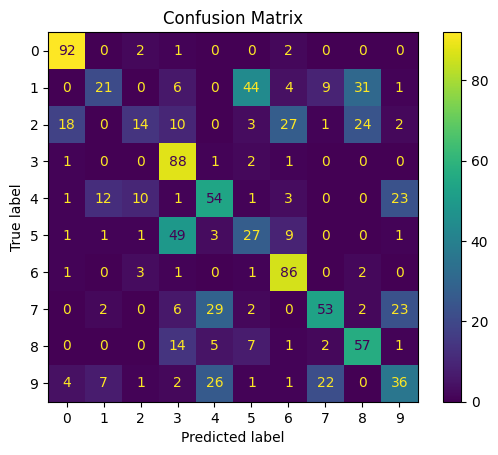

<Figure size 640x480 with 0 Axes>

In [15]:
predicted = np.argmax(voltage_map.voltage_maps, axis=0)
correct = y[:1000]

num_incorrect = np.sum(predicted != correct)

accuracy = np.mean(predicted == correct)
error_rate = 1 - accuracy

print(f"Incorrect predictions: {num_incorrect}/{len(compressed_set)}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Error Rate: {error_rate:.2%}")

cm = confusion_matrix(correct, predicted, labels=np.arange(10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()
plt.clf()

len(transformed_points) 1000


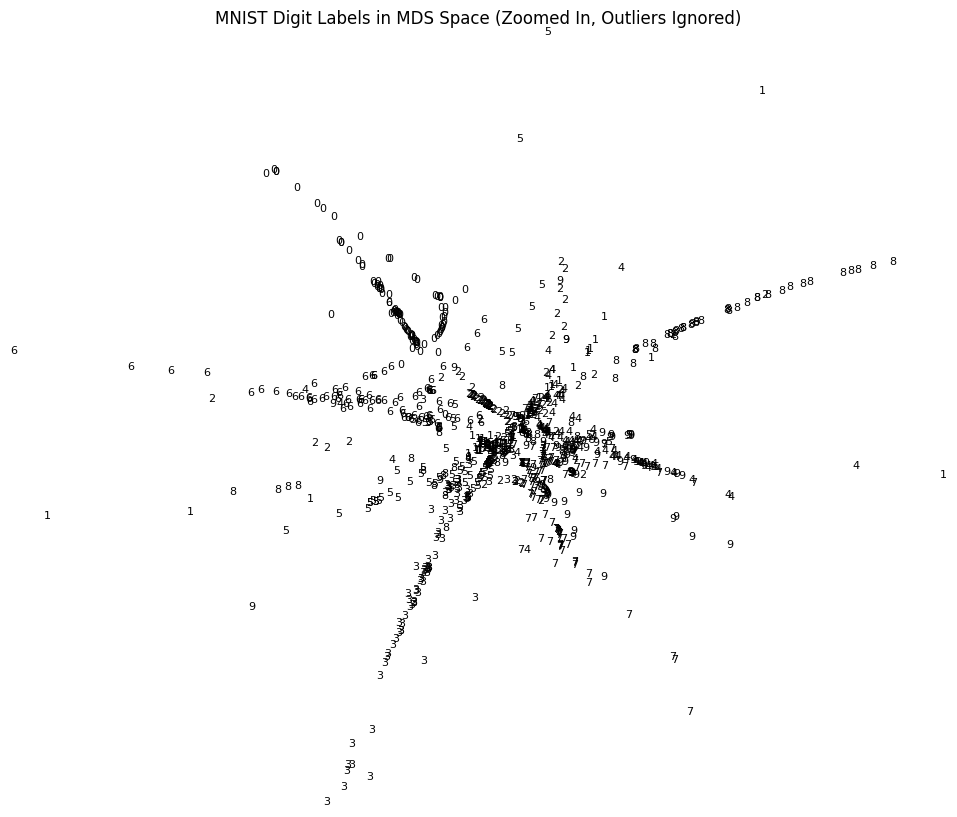

In [16]:
# Step 1: Calculate distances from the mean (or median) of all points
center = np.mean(transformed_points, axis=0)
distances = np.linalg.norm(transformed_points - center, axis=1)
print('len(transformed_points)', len(transformed_points))
# Step 2: Find the indices of the 10 most distant points
outlier_indices = np.argsort(distances)[-10:]

# Step 3: Get the mask of inliers (non-outliers)
mask = np.ones(len(transformed_points), dtype=bool)
mask[outlier_indices] = False

# Step 4: Get the non-outlier (central cluster) points
inlier_points = transformed_points[mask]

# Plot with zoom-in
fig, ax = plt.subplots(figsize=(12, 10))
for i in np.where(mask)[0]:
    ax.text(transformed_points[i, 0], transformed_points[i, 1], str(correct[i]),
            color='black', fontsize=8, alpha=1,
            ha='center', va='center')

# Set axis limits based on inlier points
ax.set_xlim(inlier_points[:, 0].min(), inlier_points[:, 0].max())
ax.set_ylim(inlier_points[:, 1].min(), inlier_points[:, 1].max())

plt.axis('off')
plt.title("MNIST Digit Labels in MDS Space (Zoomed In, Outliers Ignored)")
plt.show()

In [17]:
def plot_mds_digits(selected_digits, voltages, data, correct, n_outliers=10, alpha_actual=1, percent_size=0.02):
    # Step 0: Filter for selected digits
    voltages = np.array(voltages)
    
    indices= [i for i, label in enumerate(correct) if label in selected_digits]
    filtered_voltages = voltages[np.ix_(selected_digits, indices)]
    points = np.array(list(map(list, zip(*filtered_voltages))))

    print('filtered_voltages.shape=',filtered_voltages.shape)
    print('points.shape=',points.shape)

    filtered_data = np.array([data[i] for i in indices])
    filtered_labels = np.array([correct[i] for i in indices])

    print('filtered_data.shape=',filtered_data.shape)
    
    # Step 1: Run MDS on voltages    
    mds = MDS(n_components=2, random_state=42)
    transformed_points = mds.fit_transform(points)

    print('transformed_points.shape=',transformed_points.shape)
    
    # Step 2: Remove outliers
    center = np.mean(transformed_points, axis=0)
    distances = np.linalg.norm(transformed_points - center, axis=1)
    outlier_indices = np.argsort(distances)[-len(selected_digits):]
    mask = np.ones(len(transformed_points), dtype=bool)
    mask[outlier_indices] = False
    inlier_points = transformed_points[mask]
    
    # Step 3: Plot MNIST images with colored alpha
    fig, ax = plt.subplots(figsize=(12, 10))

    # Assign distinct colors for each digit
    colors = [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]]
    
    digit_colors = {}

    for i, label in enumerate(selected_digits):
        digit_colors[label] = colors[i]

    x_bound = (inlier_points[:, 0].min(), inlier_points[:, 0].max())
    y_bound = (inlier_points[:, 1].min(), inlier_points[:, 1].max())

    image_size = (x_bound[1] + y_bound[1] - x_bound[0] - y_bound[0]) * percent_size / 2
    
    for i in np.where(mask)[0]:
        alpha_mask = np.clip(filtered_data[i].reshape(28, 28), 0, 1)

        label = filtered_labels[i]
        color = np.array(digit_colors[label])
        
        # Create RGBA image
        rgb_image = np.zeros((28, 28, 4))
        for c in range(3):
            rgb_image[..., c] = color[c]
        rgb_image[..., 3] = alpha_mask * alpha_actual  # Alpha from pixel intensity

        x, y = transformed_points[i]
        ax.imshow(rgb_image, extent=(x - image_size, x + image_size, y - image_size, y + image_size), origin='upper')
    
    ax.set_xlim(x_bound[0] - image_size, x_bound[1] + image_size)
    ax.set_ylim(y_bound[0] - image_size, y_bound[1] + image_size)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    plt.title("MDS Visualization of Digits: " + ", ".join(map(str, selected_digits)))
    plt.show()

filtered_voltages.shape= (1, 97)
points.shape= (97, 1)
filtered_data.shape= (97, 784)
transformed_points.shape= (97, 2)


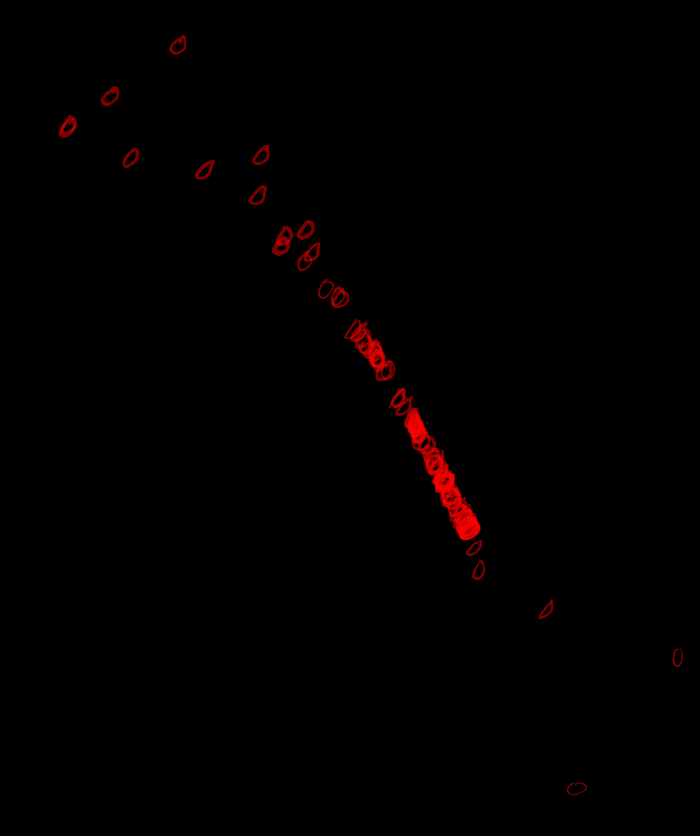

In [25]:
plot_mds_digits([2, 3, 4, 5, 7, 8, 9], voltage_map.voltage_maps, compressed_set, correct, alpha_actual=0.5)

# Simple Points

Some experiments with changing resistance to the ground.

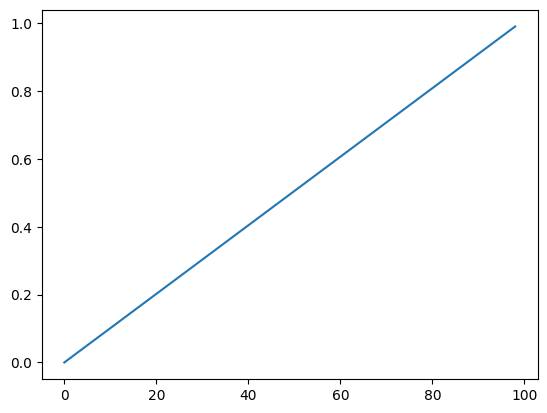

In [19]:
n=99
points = np.array([ [x] for x in np.arange(0,1,1.0/n)])
simple_set = setofpoints.SetOfPoints(points)
plt.plot(points);

In [20]:
simple_problem = problem.Problem(simple_set, r=1)
simple_problem.calcResistanceMatrix(k=2, universalGround=True)

array([[ 1.        , -0.49495001, -0.49495001, ...,  0.        ,
         0.        , -0.01009999],
       [-0.49495001,  1.        , -0.49495001, ...,  0.        ,
         0.        , -0.01009999],
       [-0.33108131, -0.33108131,  1.        , ...,  0.        ,
         0.        , -0.00675607],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.49495001, -0.01009999],
       [ 0.        ,  0.        ,  0.        , ..., -0.49495001,
         1.        , -0.01009999],
       [-0.01010101, -0.01010101, -0.01010101, ..., -0.01010101,
        -0.01010101,  1.        ]])

In [21]:
def solve(r):
    simple_problem = problem.Problem(simple_set, r=r)
    simple_solver = solver.Solver(problem=simple_problem)
    return simple_solver.compute_voltages(landmarks=[landmark.Landmark(n//2, 1)], k=2, universalGround=True)

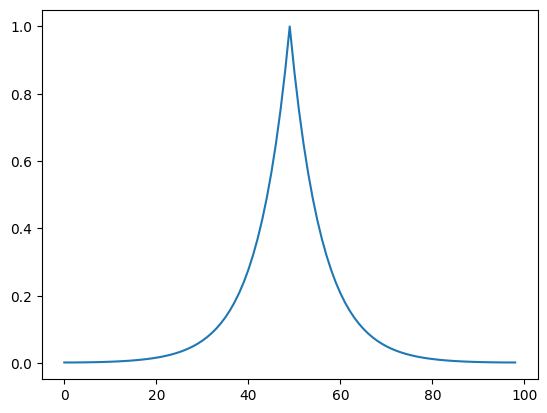

In [22]:
plt.plot(solve(1))

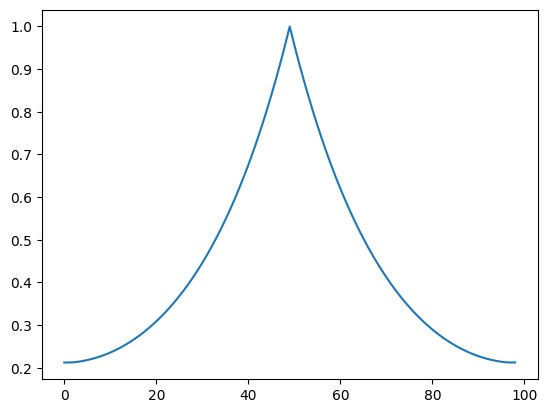

In [23]:
plt.plot(solve(10))

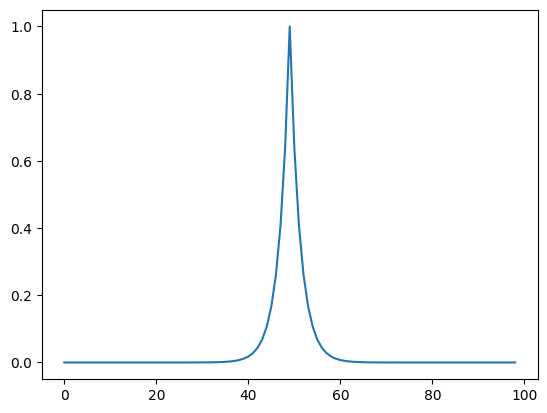

In [24]:
plt.plot(solve(0.1))